## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

### Introduction
In this notebook we have carried out the following tasks:
- implemented a Class Activation Map (CAM) on a VGG_16 model architectute
- implemented a CAM on a ResNet_34 model architectute
- implemented a Grad-CAM on a ResNet_34 model architectute
- implemented saliency maps

We will then compare the results from all these different approaches.
Please enable GPU usage if possible. It is needed for the re-training of the VGG_16 model.

In [1]:
import torch
import torch.nn as nn
import matplotlib.image as mpimg
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import pickle
import urllib.request
import numpy as np
from PIL import Image
import os
import cv2
import copy
import torch.utils.data as Data
import torchvision.transforms as trans
import os
import requests
from zipfile import ZipFile

%matplotlib inline

In [2]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"

if device != "mps":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.1.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [3]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [4]:
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data/TP2_images")
if not os.path.exists("data/TP2_images/images"):
    os.mkdir("data/TP2_images/images")

url = "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip"
download_path = "data/TP2_images/TP2_images.zip"

response = requests.get(url)
with open(download_path, "wb") as f:
    f.write(response.content)

with ZipFile(download_path, "r") as zip_ref:
    zip_ref.extractall("data/TP2_images/images/")

In [5]:
dir_path = "data/TP2_images/"
dataset = preprocess_image(dir_path)


In [6]:
url = "https://drive.google.com/uc?export=download&id=1ceB2HPOBl9MPk2pVNcZ2h89ni4OofCfw"
download_path = "data/VGG_16.png"

response = requests.get(url)
with open(download_path, "wb") as f:
    f.write(response.content)

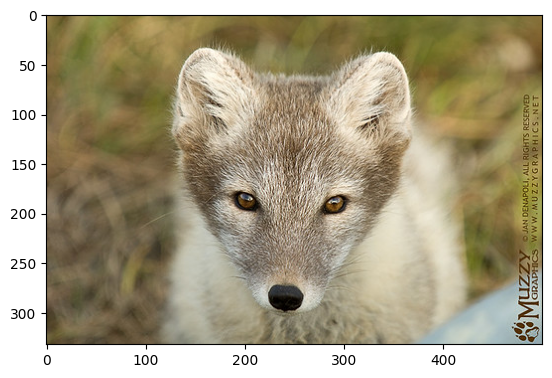

In [7]:
# show the orignal image
index = 6
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

# CAM

Before implementing Grad_CAM, let's implement a simpler Class Activation Map (CAM). This way we can compare the results from this two different methods. We will first implement a CAM function on a VGG 16 model and then on a ResNet34 model. 

### VGG16
As CAM uses GAP (Global Averega Pooling) to replace fully-connected (FC) layers, we start by removing the FC layer of VGG16.

<img src='VGG_16.png' alt="VGG_16" width="50%">


In [8]:
# image_path = "data/VGG_16.png"

# # Load the image using matplotlib.image.imread
# img = mpimg.imread(image_path)

# # Display the image using matplotlib.pyplot.imshow
# plt.imshow(img)
# plt.axis('off')  # Hide axis
# plt.show()


In [9]:
vgg = torchvision.models.vgg16(pretrained=True)
print('VGG16 Architecture:\n', vgg)


/Users/enricobarchiesi/anaconda3/envs/conda-env-NLP/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/enricobarchiesi/anaconda3/envs/conda-env-NLP/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16 Architecture:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, 

#### Train VGG16
As we have modified the architecture of VGG16, we need to train it first. And we only need to train the FC laye (i.e. the GAP) of the network. To do so, we will use the he Hymenoptera dataset, which is a collection of images commonly used for image classification tasks in machine learning, consisting primarily of two classes: ants and bees. It is often utilized to train and evaluate algorithms for distinguishing between these insect species based on visual characteristics.

In [10]:
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/hymenoptera_data"):
    os.mkdir("data/hymenoptera_data")

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"    

download_path = "data/hymenoptera_data/hymenoptera_data.zip"

response = requests.get(url)
with open(download_path, "wb") as f:
    f.write(response.content)

with ZipFile(download_path, "r") as zip_ref:
    zip_ref.extractall("data/")

In [11]:
root_dir = 'data/hymenoptera_data'

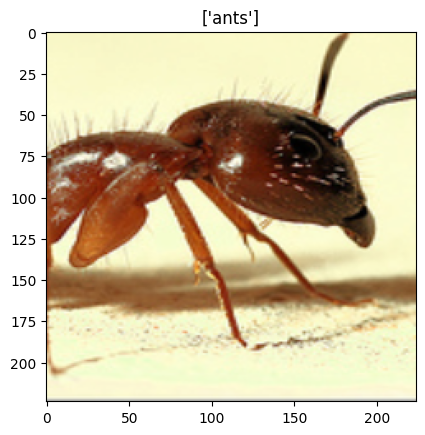

In [12]:
data_transforms = {
    'train': trans.Compose([
        trans.RandomResizedCrop(224),
        trans.RandomHorizontalFlip(),
        trans.ToTensor(),
        # when do the transform, image pixels are compressed 
        # from (0,255) to (0,1) then we do the normalization
        trans.Normalize([0.485, 0.456, 0.406], # mean of RGB
                        [0.229, 0.224, 0.225]) # std of RGB
    ]), 
    'val': trans.Compose([
        trans.Resize(256),
        trans.CenterCrop(224),
        trans.ToTensor(),
        trans.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    
}


train_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'train'),
    transform=data_transforms['train']
)


val_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'val'),
    transform=data_transforms['val']
)


class_names = train_data.classes
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

dataloaders = {  
    'train': Data.DataLoader(
        dataset=train_data,
        batch_size=1,
        shuffle=True,
    ),

    'val': Data.DataLoader(
        dataset=val_data,
        batch_size=1,
        shuffle=True,
    ),    
}

# denormalize and show an image 
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)

# get a batch of training data
images, classes = next(iter(dataloaders['train']))

# make a grid from batch
images = torchvision.utils.make_grid(images)

imshow(images, title=[class_names[x] for x in classes])


In [13]:
# reconstruct VGG16, i.e. remove the classifier and replace it with GAP
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True) 
        self.conv = nn.Sequential(
            self.vgg.features, 
            self.vgg.avgpool 
        )
         
        # self.fc = nn.Linear(512, num_of_class)
        # as we use ImageNet, num_of_class=1000
        self.fc = nn.Linear(512, 1000)

    
    def forward(self,x):    
        x = self.conv(x) # -> (512, 7, 7)
        
        # we use GAP to replace the fc layer, therefore we need to
        # convert (512,7,7) to (512, 7x7)(i.e. each group contains 7x7=49 values), 
        # then convert (512, 7x7) to (512, 1x1) by mean(1)(i.e. average 49 values in each group), 
        # and finally convert (512, 1) to (1, 512) 
        x = x.view(512,7*7).mean(1).view(1,-1) # -> (1, 512)
        
        # FW^T = S
        # where F is the averaged feature maps, which is of shape (1,512)
        # W is the weights for fc layer, which is of shape (1000, 512)
        # S is the scores, which is of shape (1, 1000)
        x = self.fc(x) # -> (1, 1000)
        return x 

In [14]:
from tqdm import tqdm

def train_model(model, loss_fn, optimizer, scheduler, device, num_epochs=25):
    """
    net: the model to be trained
    loss_fn: loss function
    scheduler: torch.optim.lr_scheduler
    device: torch.device - specify where you want to move your model and data
    """
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set to training mode
            else:
                model.eval() # set to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            data_loader = tqdm(dataloaders[phase], desc=f'{phase} epoch {epoch}', leave=False)
            
            for images, labels in data_loader:
                images = images.to(device)  # Move images to GPU
                labels = labels.to(device)  # Move labels to GPU
               
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images) 
                    preds = torch.max(outputs, 1)[1]
                    loss = loss_fn(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.float() / dataset_sizes[phase]  # Ensure conversion to float32
            
            # Append accuracy to appropriate list
            if phase == 'train':
                train_acc.append(epoch_accuracy)
            else:
                val_acc.append(epoch_accuracy)
            
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_accuracy))

            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
            
        print()
        
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))

    # Convert train_acc and val_acc to numpy arrays before plotting
    train_acc_np = [acc.item() for acc in train_acc]
    val_acc_np = [acc.item() for acc in val_acc]

    # draw the loss history and accuracy history
    x = np.arange(num_epochs)
    plt.subplot(221)
    plt.plot(x, train_loss, c='red', label='train loss')
    plt.plot(x, val_loss, c='blue', label='val loss')
    plt.legend(loc='best')

    plt.subplot(222)
    plt.plot(x, train_acc_np, c='red', label='train acc')  # Convert train_acc to numpy array
    plt.plot(x, val_acc_np, c='blue', label='val acc')      # Convert val_acc to numpy array
    plt.legend(loc='best')

    plt.show()


    # load best model weights
    model.load_state_dict(best_model_weights)
    return model


In [15]:
# generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training # if true, the model is in training mode otherwise in evaluate mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for step, (images, labels) in enumerate(dataloaders['val']): 
        images = images.to(device)  # Move images to the same device as the model
        outputs = model(images)
        preds = torch.max(outputs, 1)[1]
        
        for i in range(images.size(0)):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[i]]))
            imshow(images.cpu().data[i])
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    
    model.train(mode=was_training)

In [16]:
model = VGG().to(device) 

trainable_parameters = []
for name, p in model.named_parameters():
    if "fc" in name:
        trainable_parameters.append(p)

loss_fn = torch.nn.CrossEntropyLoss().to(device) 

# all parameters are being optimized
optimizer = torch.optim.SGD(trainable_parameters, lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Epoch 0/9
----------


train epoch 0:   0%|          | 0/244 [00:00<?, ?it/s]

train Loss: 0.8617 Accuracy: 0.8443


val Loss: 0.2784 Accuracy: 0.9346

Epoch 1/9
----------


train Loss: 0.2671 Accuracy: 0.9426


val Loss: 0.2456 Accuracy: 0.9216

Epoch 2/9
----------


train Loss: 0.2362 Accuracy: 0.9426


val Loss: 0.2133 Accuracy: 0.9412

Epoch 3/9
----------


train Loss: 0.2003 Accuracy: 0.9426


val Loss: 0.2410 Accuracy: 0.9150

Epoch 4/9
----------


train Loss: 0.1747 Accuracy: 0.9344


val Loss: 0.2212 Accuracy: 0.9281

Epoch 5/9
----------


train Loss: 0.1300 Accuracy: 0.9672


val Loss: 0.2082 Accuracy: 0.9412

Epoch 6/9
----------


train Loss: 0.1771 Accuracy: 0.9549


val Loss: 0.1830 Accuracy: 0.9477

Epoch 7/9
----------


train Loss: 0.0887 Accuracy: 0.9795


val Loss: 0.1837 Accuracy: 0.9412

Epoch 8/9
----------


train Loss: 0.1557 Accuracy: 0.9508


val Loss: 0.1856 Accuracy: 0.9346

Epoch 9/9
----------


train Loss: 0.0869 Accuracy: 0.9836


val Loss: 0.1850 Accuracy: 0.9412

Best Validation Accuracy: 0.947712


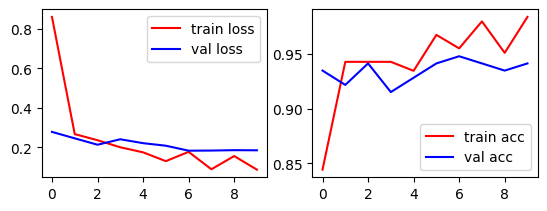

In [17]:
model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, device, num_epochs=10)


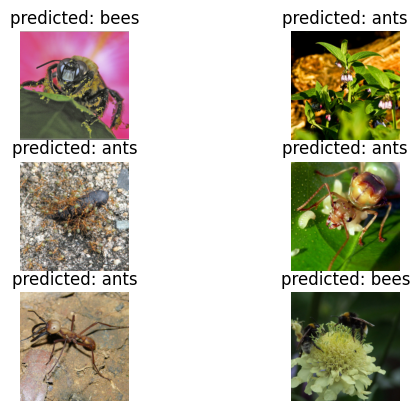

In [18]:
visualize_model(model)

### Generate CAM
Now that we have trained the model, let's extract the weights for the FC layer, which is of shape (1000, 512)

In [19]:
# Get the parameters of the fully connected layer (model.fc)
params = list(model.fc.parameters())

# Extract the weight tensor from the parameters
weight_tensor = params[0]

# Move the weight tensor to CPU and then convert it to a NumPy array
weight_array = weight_tensor.cpu().data.numpy()

print('weight.shape', weight_array.shape)


weight.shape (1000, 512)


In [20]:
image, label = next(iter(dataloaders['val']))

# Move the input image tensor to the same device as the model
image = image.to(device)

# Set the model to evaluation mode
model.eval()

# Get the raw scores
scores = model(image)

# Use softmax to generate the probability distribution for the scores
probs = F.softmax(scores, dim=1).data.squeeze()

# Sort the probability distribution in descending order
probs, idx = probs.sort(0, True)

# Print the sum of probabilities, true class, and predicted class
print('sum of probabilities: %.0f' % torch.sum(probs).cpu().numpy())
print('true class: ', class_names[label])
print('predicted class: ', class_names[idx[0].cpu().numpy()])



sum of probabilities: 1
true class:  ants
predicted class:  ants


feature_maps.shape:  torch.Size([1, 512, 7, 7])
original image shape:  (224, 224, 3)
heatmap.shape: (224, 224, 3)


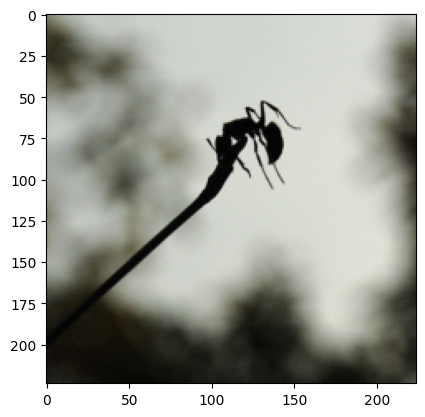

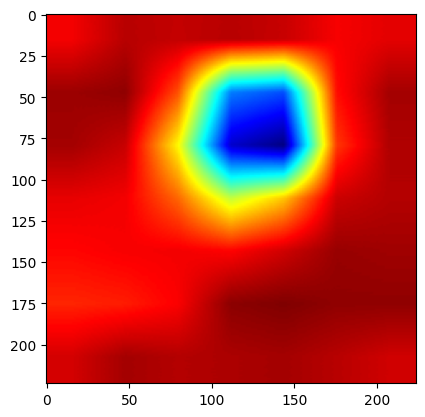

In [21]:
def CAM(feature_conv, weight, class_idx):
    """
    CAM generates the CAMs and up-sample it to 224x224
    arguments:
    feature_conv: the feature maps of the last convolutional layer
    weight: the weights that have been extracted from the trained parameters
    class_idx: the label of the class which has the highest probability
    """
    size_upsample = (224, 224)
    # we only consider one input image at a time, therefore in the case of 
    # VGG16, the shape is (1, 512, 7, 7)
    bz, nc, h, w = feature_conv.shape 
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))# -> (512, 49)
        cam = np.matmul(weight[idx], beforeDot) # -> (1, 512) x (512, 49) = (1, 49)
        cam = cam.reshape(h, w) # -> (7 ,7)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

if class_names[idx[0].cpu().numpy()] == 'bees':
    idx = torch.tensor([1]).to(device) 
else:
    idx = torch.tensor([0]).to(device) 

with torch.no_grad():
    feature_maps = model.conv(image)  # get the feature maps of the last convolutional layer
    print('feature_maps.shape: ', feature_maps.shape)

    CAMs = CAM(feature_maps.cpu().numpy(), weight_array, [idx.item()])  # generate the CAM for the input image
    heatmap = cv2.applyColorMap(CAMs[0], cv2.COLORMAP_JET)

    print('original image shape: ', image.cpu().numpy().squeeze().transpose((1, 2, 0)).shape)
    print('heatmap.shape:', heatmap.shape)
    image_numpy = image.cpu().numpy().squeeze().transpose((1, 2, 0))

    # Perform mean and std normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_numpy = image_numpy * std + mean
    image_numpy = np.clip(image_numpy, 0, 1)

    plt.imshow(image_numpy)
    plt.show()
    plt.imshow(heatmap)
    plt.show()


### ResNet 34
Let's now create a CAM using a ResNet34 model. Since Global Average Pooling is already present in the model architecture, in this case we do not need to modify and retrain the model. We just have to extract the weights after the GAP layer and the fetaures layers of the last convolutional layer.

In [22]:
resnet34 = models.resnet34(weights='ResNet34_Weights.IMAGENET1K_V1')  # New PyTorch interface for loading weights!
resnet34.eval() # set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224).

First convolution layer with maxpool.
Then 4 ResNet blocks.

Output of the last ResNet block is of size (512x7x7).

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [23]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class
# print(classes)

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [24]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Note: If the inverse normalisation is required, apply 1/x to the above object

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [25]:
import os
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP2_images"):
    os.mkdir("data/TP2_images")
    !cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip

dir_path = "data/TP2_images/"
dataset = preprocess_image(dir_path)

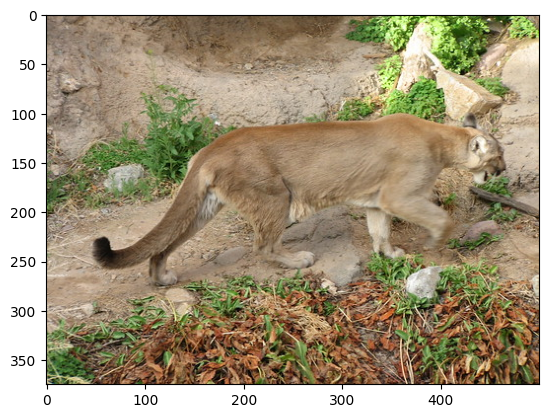

In [26]:
# show the orignal image
index = 14
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

In [27]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [286 291 287] ['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'lynx, catamount']
Raw class scores: [19.177502 16.290874 13.312032]


### Change the last layers of the model

In [28]:
def generate_CAM(model, img_number, class_index, size=(224, 224), dataset=None, classes=None):
    # Convert image to the appropriate type
    image = Image.open(dataset.imgs[img_number][0]).convert('RGB')
    output = model(dataset[img_number][0].view(1, 3, 224, 224))
    values, indices = torch.topk(output, 3)
    print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
    print("Raw class scores:", values[0].detach().numpy())
    
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Extract weights from the last FC layer
    m_weights = model.fc.weight.data[class_index]

    # Remove last 2 layers
    newmodel = torch.nn.Sequential(*(list(model.children())[:-2]))

    # Forward pass
    fms = newmodel(image_tensor)
    fms = fms.squeeze(0)
    out_t = fms * m_weights[:, None, None]
    y_0 = torch.mean(out_t, dim=0)

    # Visualization
    plt.figure(figsize=(30, 12))
    ax = plt.subplot(1, 3, 1)
    ax.axis("off")
    plt.imshow(image)

    ax = plt.subplot(1, 3, 2)
    ax.axis("off")
    plt.imshow(y_0.detach().numpy())

    ax = plt.subplot(1, 3, 3)
    ax.axis("off")
    ax.imshow(image)
    ax.imshow(y_0.detach().numpy(), alpha=0.6, interpolation="bilinear", cmap="magma",
              extent=(0, image.size[0], image.size[1], 0))
    plt.show()
    print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

Top 3-classes: [286 291 287] ['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'lynx, catamount']
Raw class scores: [19.177502 16.290874 13.312032]


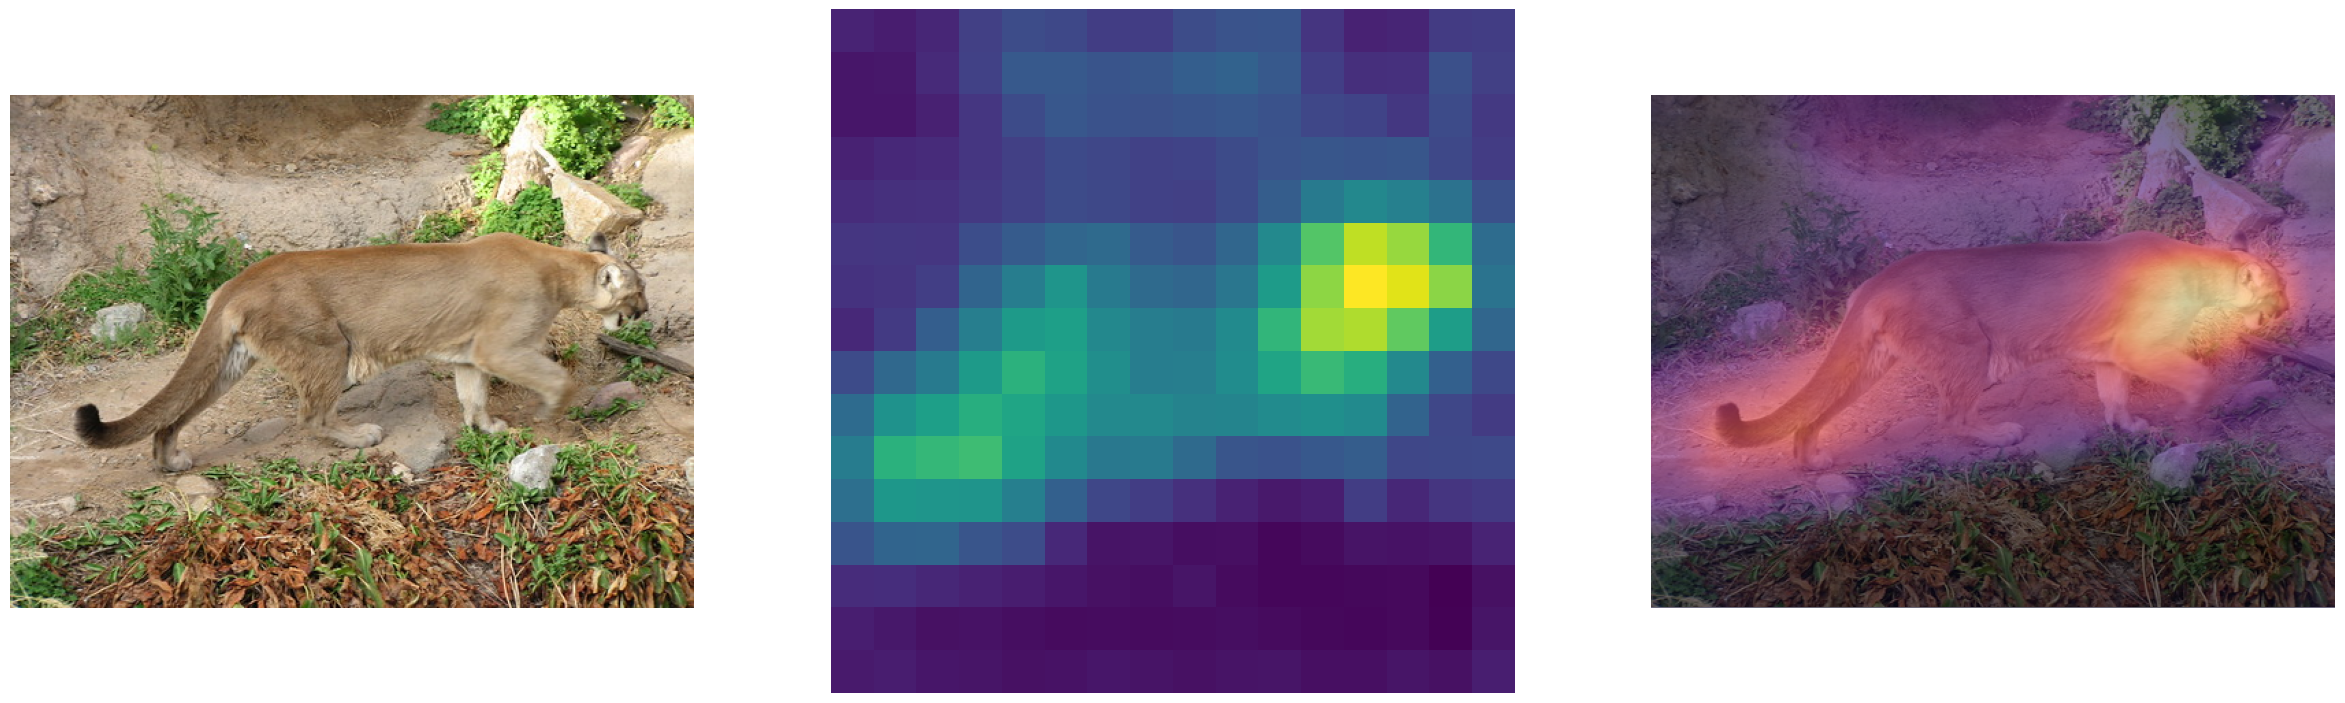

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [29]:
generate_CAM(resnet34, index, int(indices[0][0].numpy()), size=(max(input_image.size), max(input_image.size)), dataset=dataset, classes=classes)

Repeating for each image

In [ ]:
# for i in range(len(dataset)):
#     generate_CAM(resnet34, i, int(indices[0][0].numpy()), size=(max(input_image.size), max(input_image.size)), dataset=dataset, classes=classes)

### Let's now implement a Grad-CAM
Both methods generate a heatmap that highlights the regions of an input image that contribute most to a specific class prediction. However, there are some differences between the two methods.  

**CAM:**
* It works by aggregating the activations of the final convolutional layer of the CNN, followed by a global average pooling operation, to obtain the class-specific activation maps.
* CAM is simple and efficient but has limitations, such as only being applicable to CNN architectures with global average pooling layers and often producing blurry heatmaps.

**Grad-CAM:**
* Grad-CAM extends CAM by utilizing the gradients of the predicted class score with respect to the final convolutional feature maps of the CNN.
* Grad-CAM is more flexible and can be applied to a wider range of CNN architectures, as it does not rely on specific layer types like global average pooling.

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | -
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

In [31]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    denormalize_transform = transforms.Normalize(
        mean=[-mean[i] / std[i] for i in range(3)],
        std=[1 / std[i] for i in range(3)]
    )

    return denormalize_transform(tensor)


In [32]:
resnet34.eval()

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        if self.target_layer == 'layer1':
          h = x.register_hook(self.save_gradient)
          self.activations = x.clone()

        x = self.model.layer2(x)
        if self.target_layer == 'layer2':
          h = x.register_hook(self.save_gradient)
          self.activations = x.clone()

        x = self.model.layer3(x)
        if self.target_layer == 'layer3':
          h = x.register_hook(self.save_gradient)
          self.activations = x.clone()

        x = self.model.layer4(x)
        if self.target_layer == 'layer4':
          h = x.register_hook(self.save_gradient)
          self.activations = x.clone()

        x = self.model.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)

        return x

    def backward(self, pred, classes):
        pred[:, classes].backward(retain_graph=True)

    def generate(self, input_image):
        output = self.forward(input_image)
        # output1 = self.model.avgpool(output)
        # output1 = output1.view(output1.size(0), -1)
        # final_output = self.model.fc(output1)

        values, indices = torch.topk(output, 3)

        heatmap = []

        for i in indices.squeeze(0):

          self.backward(output, i)

          pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
          #weighted_activations = torch.matmul(pooled_gradients, activations)

          for i in range(self.activations.shape[1]):
              self.activations[:, i, :, :] *= pooled_gradients[i]

          weighted_activations = torch.mean(self.activations, dim=1).squeeze()
          cam = F.relu(weighted_activations).unsqueeze(0).unsqueeze(1)

          cam = F.interpolate(cam, size=(224, 224), mode="bilinear", align_corners=False)
          cam = cam.squeeze(0).squeeze(0)

          cam = cam - cam.min()
          cam = cam / cam.max()

          heatmap.append(cam.detach().numpy())

        return heatmap, indices.squeeze().detach().numpy()



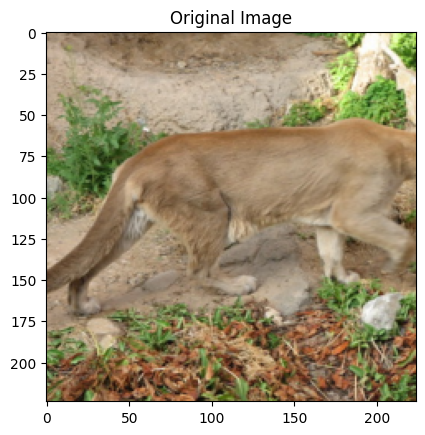

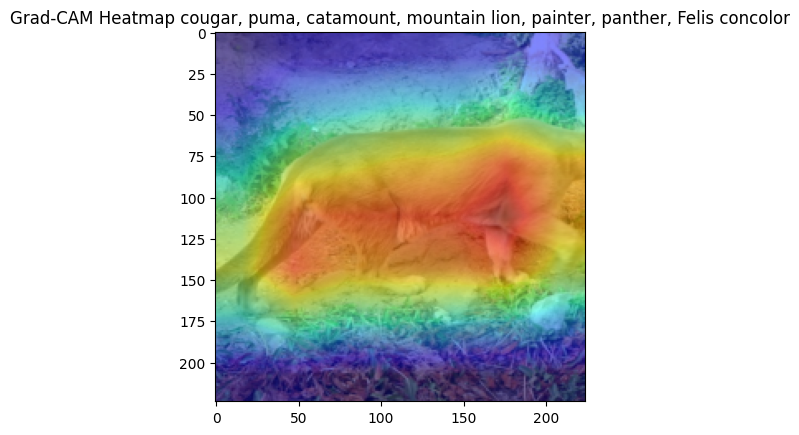

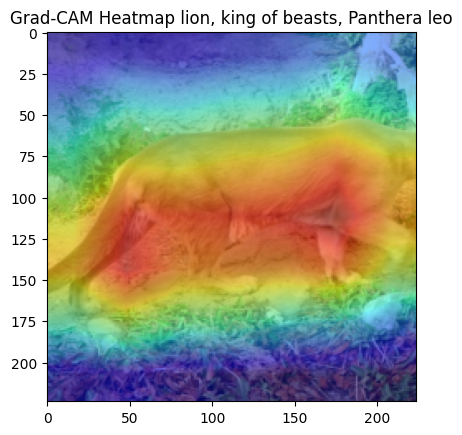

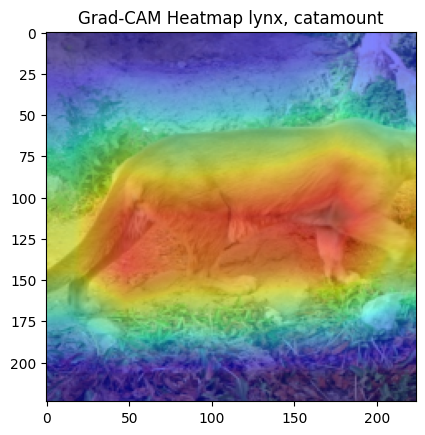

In [33]:
image = dataset[index][0].view(1, 3, 224, 224)

gradcam = GradCAM(resnet34, target_layer='layer4')

heatmap, indices = gradcam.generate(image)


# Load and display the original image
original_image = denormalize(image).permute(0, 2, 3, 1).squeeze()
plt.imshow(original_image)
plt.title('Original Image')
plt.show()

for x in range(len(heatmap)):

  plt.imshow(original_image)
  plt.imshow(heatmap[x], alpha=0.5, cmap='jet')
  plt.title(f'Grad-CAM Heatmap {classes[indices[x]]}')
  plt.show()

##### Let's try GradCAM on others convolutional layers and describe results

tensor([[19.1775, 16.2909, 13.3120]], grad_fn=<TopkBackward0>)


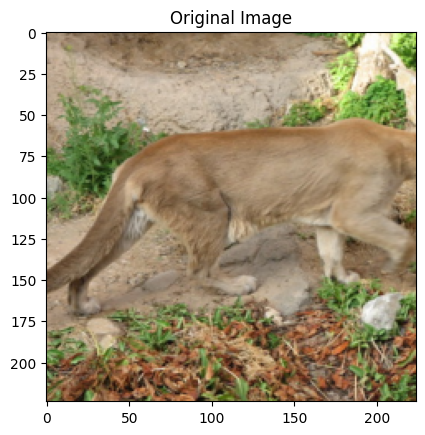

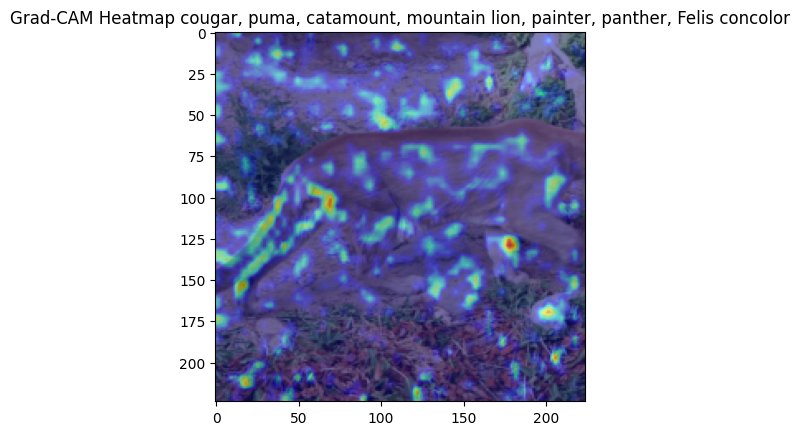

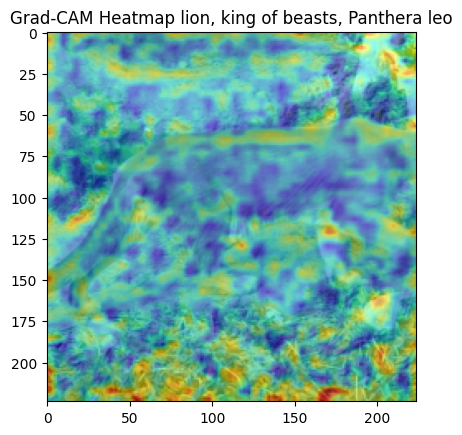

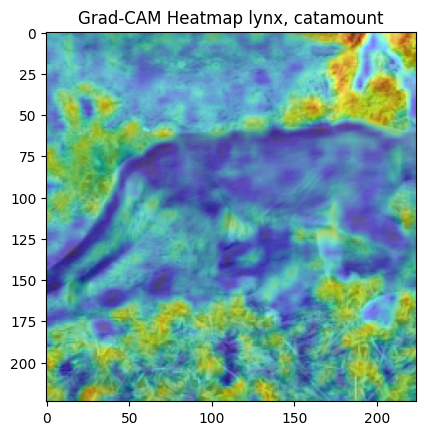

In [34]:
image = dataset[index][0].view(1, 3, 224, 224)

gradcam = GradCAM(resnet34, target_layer='layer1')

heatmap, indices = gradcam.generate(image)

print(values)

# Load and display the original image
original_image = denormalize(image).permute(0, 2, 3, 1).squeeze()
plt.imshow(original_image)
plt.title('Original Image')
plt.show()

for x in range(len(heatmap)):

  plt.imshow(original_image)
  plt.imshow(heatmap[x], alpha=0.5, cmap='jet')
  plt.title(f'Grad-CAM Heatmap {classes[indices[x]]}')
  plt.show()

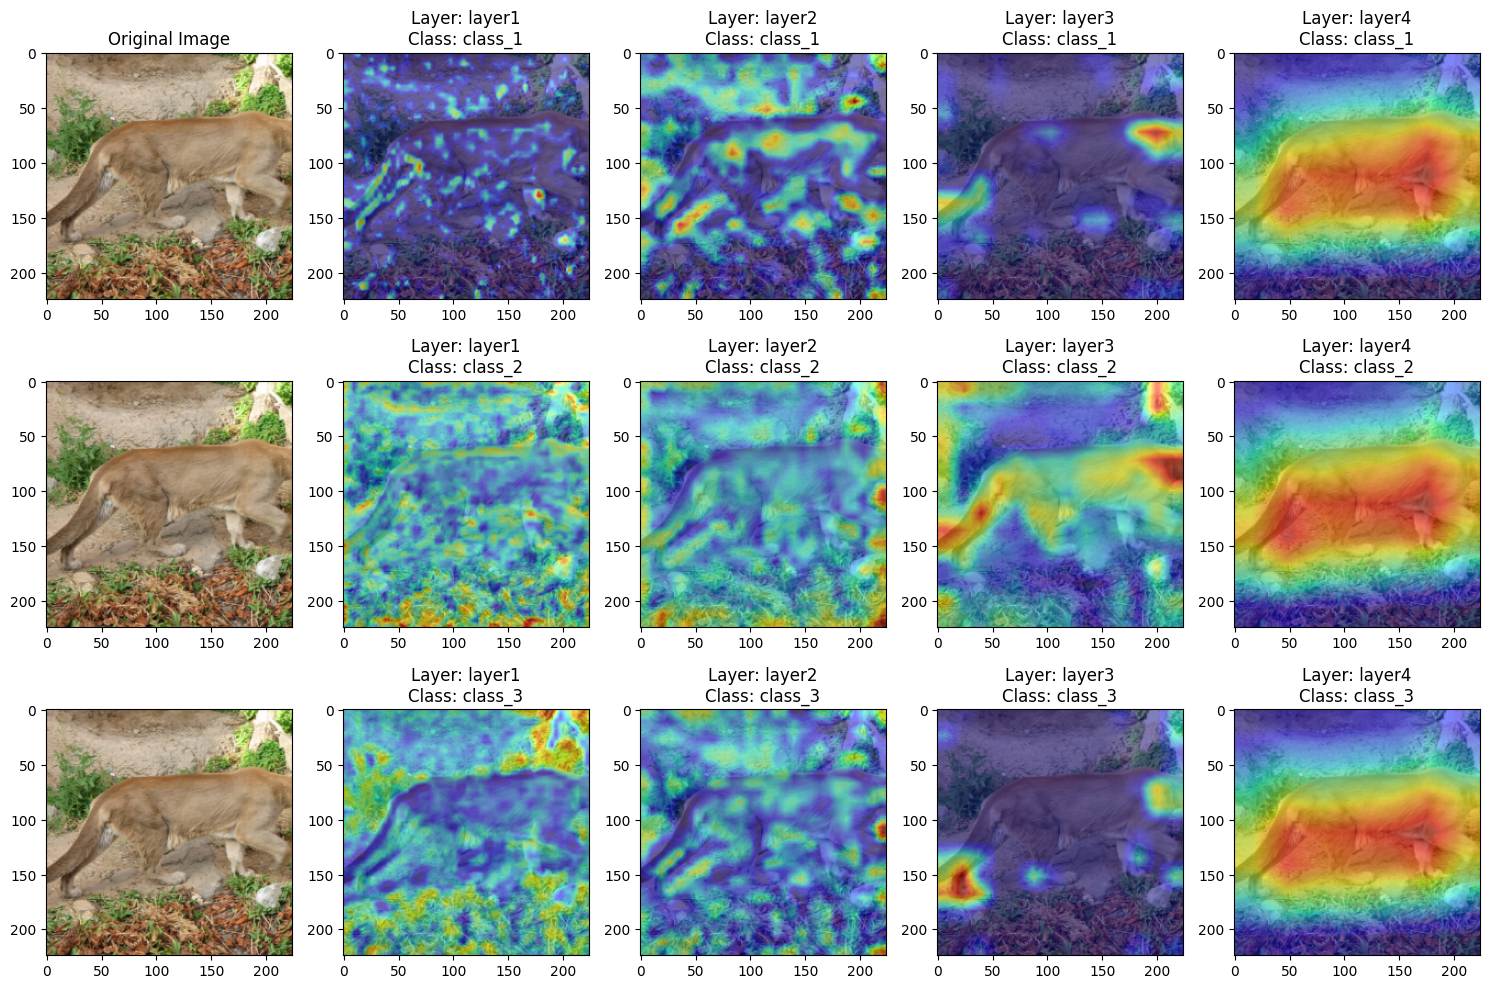

In [35]:
image = dataset[index][0].view(1, 3, 224, 224)

# List of target layers
target_layers = ['layer1', 'layer2', 'layer3', 'layer4']

# Number of rows and columns in the subplot grid
num_rows = 3
num_cols = len(target_layers)

# Create a GradCAM instance for each target layer
gradcams = [GradCAM(resnet34, target_layer=layer) for layer in target_layers]

# Initialize subplots
fig, axs = plt.subplots(num_rows, num_cols + 1, figsize=(15, 10))

# Load and display the original image
original_image = denormalize(image).permute(0, 2, 3, 1).squeeze()
axs[0, 0].imshow(original_image)
axs[1, 0].imshow(original_image)
axs[2, 0].imshow(original_image)
axs[0, 0].set_title('Original Image')

# Iterate through each class
for i, class_label in enumerate(["class_1", "class_2", "class_3"]):
    # Iterate through each target layer
    for j, gradcam in enumerate(gradcams):
        # Generate Grad-CAM heatmap for the current class and layer
        heatmap, indices = gradcam.generate(image)
        axs[i, j + 1].imshow(original_image)
        axs[i, j + 1].imshow(heatmap[i], alpha=0.5, cmap='jet')
        axs[i, j + 1].set_title(f'Layer: {target_layers[j]}\nClass: {class_label}')

# Adjust layout
plt.tight_layout()
plt.show()

#### Grad-CAM Visualization on Different Layers
When applying the Gradient-weighted Class Activation Map (Grad-CAM) technique to different layers of a convolutional neural network (CNN), such as the initial layer versus the final layer of a ResNet-34 architecture, the resulting visualizations would show different levels of granularity and abstraction.

##### Initial Layers (e.g., Convolutional Layers):

- Grad-CAM applied to initial layers of a CNN tends to focus on low-level features such as edges, corners, and textures. These layers capture basic visual patterns in the input image.
- The resulting heatmaps from these layers might highlight fine-grained details that are essential for localizing specific objects or parts of objects. For example, in the case above the network is classifying a fox, and these initial layers might highlight the outline of the fox's ears, nose, and fur texture.

##### Final Layers (e.g., Fully Connected or Global Average Pooling Layers):

- Grad-CAM applied to final layers of a CNN captures high-level semantic information relevant to the target class. These layers integrate information from lower layers to make the final classification decision.
- The resulting heatmaps from these layers tend to highlight more global and holistic features that are discriminative for the target class. For instance, if the network is classifying a car, the final layers might focus on the overall shape, wheels, and other distinctive features characteristic of cars.

In summary, applying Grad-CAM to different layers of a CNN provides insights into how the network processes information at different levels of abstraction, from low-level features to high-level semantics.

Repeat for every image

In [36]:
def Grad_CAM_layers(image_number):
    image = dataset[image_number][0].view(1, 3, 224, 224)
    # List of target layers
    target_layers = ['layer1', 'layer2', 'layer3', 'layer4']

    # Number of rows and columns in the subplot grid
    num_rows = 3
    num_cols = len(target_layers)

    # Create a GradCAM instance for each target layer
    gradcams = [GradCAM(resnet34, target_layer=layer) for layer in target_layers]

    # Initialize subplots
    fig, axs = plt.subplots(num_rows, num_cols + 1, figsize=(15, 10))

    # Load and display the original image
    original_image = denormalize(image).permute(0, 2, 3, 1).squeeze()
    axs[0, 0].imshow(original_image)
    axs[1, 0].imshow(original_image)
    axs[2, 0].imshow(original_image)
    axs[0, 0].set_title('Original Image')

    # Iterate through each class
    for i, class_label in enumerate(["class_1", "class_2", "class_3"]):
        # Iterate through each target layer
        for j, gradcam in enumerate(gradcams):
            # Generate Grad-CAM heatmap for the current class and layer
            heatmap, indices = gradcam.generate(image)
            axs[i, j + 1].imshow(original_image)
            axs[i, j + 1].imshow(heatmap[i], alpha=0.5, cmap='jet')
            axs[i, j + 1].set_title(f'Layer: {target_layers[j]}\nClass: {class_label}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
# for i in range(len(dataset)):
#     Grad_CAM_layers(i)

## Saliency Map

Let's now implement a saliency map and visualize its result on a few images.

Top 3 classes: [286 291 287] ['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lion, king of beasts, Panthera leo', 'lynx, catamount']
Raw class scores: [19.177502 16.290874 13.312032]


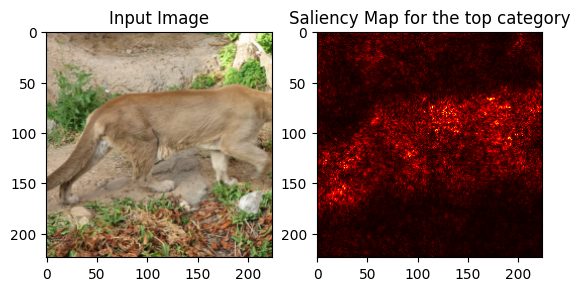

In [38]:
# Define a function to generate the saliency map
def generate_saliency_map(model, input_image, target_class=None):
    input_image.requires_grad = True
    model.eval()
    output = model(input_image)
    model.zero_grad()

    if target_class is None:
        target_class = output.argmax()  # Get the index of the predicted class

    # Compute gradients with respect to the output of the target class
    output[0, target_class].backward()

    gradients = input_image.grad.data
    saliency_map = gradients.abs().max(dim=1)[0]
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-10)

    return saliency_map.squeeze().cpu().numpy()


# for i in range(len(dataset)-):
    # Compute the output of the model
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)

print("Top 3 classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

# Generate the saliency map for the highest predicted class
saliency_map = generate_saliency_map(resnet34, dataset[index][0].view(1, 3, 224, 224), target_class=indices[0][0])

# Plot the input image and its saliency map
plt.subplot(1, 2, 1)
plt.imshow(denormalize(dataset[index][0]).permute(1, 2, 0).numpy())  # Display the input image
plt.title('Input Image')


plt.subplot(1, 2, 2)
plt.imshow(saliency_map, cmap='hot')  # Display the saliency map
plt.title(f'Saliency Map for the top category')

plt.show()


#### Why Is Grad-CAM Better than Saliency Maps ? 
Grad-CAM utilizes gradients of the target class score with respect to the feature maps of the last convolutional layer, which provides richer information about the importance of different spatial locations within the image. This depth of information allows Grad-CAM to generate more informative visualizations compared to saliency maps, which rely solely on gradients with respect to the input image pixels.